# Introduction

The Herschel/SPIRE Spectral Feature Finder (FF) is an automated tool which detects significant spectral features within SPIRE Fourier Transform Spectrometer (FTS) spectral data. The FF is designed to facilitate data-mining and preliminary analysis of SPIRE spectral data and is not a replacement for detailed scientific analysis. A full introduction to the FF routine and products is presented at http://archives.esac.esa.int/hsa/legacy/HPDP/SPIRE/SPIRE-S/spectral_feature_catalogue/SpectralFeatureFinder_releaseNote.html The FF products can be accessed from https://www.cosmos.esa.int/web/herschel/spire-spectral-feature-catalogue. In this notebook we provide examples of how to search FF products for spectral lines or sources on interest, and include sample code for visually displaying the results and estimating integrated line flux. 

The full FF products can be downloaded from the link above, however, in this notebook we will only download select products when necessary. Products will be downloaded from the `archive` defined below and will be placed in a chosen directory which we will assing to the variable `dataDir`. The `archive` has a directory sturcture identical to the FF products you can download from the link above.

To begin, a few Python modules will need to be imported. The standard Anaconda distribution is recomended as it includes most of these packages by default. However, Anaconda does not ship with the spectral-cube or lmfit packages and likely need to be installed by the user.

## Requirements

The notebook was developed and need python 3.7 and the following packages with their versions:
 * `astropy v3.1`
 * `numpy v1.15.4` 
 * `matplotlib 3.0.2`
 * `spectral-cube v0.4.3`
 * `lmfit`
 and some standard pyhton packages. 

In [17]:
import os
import io
import requests
import gzip
import tarfile
#import webbrowser
import urllib3
http = urllib3.PoolManager()

import numpy as np
from lmfit import Model

from astropy import units as u
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.table import Table

from spectral_cube import SpectralCube

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline  

In [22]:
#
# define the URL for the FTS Spectral Feature Catalogue
#
archive = 'http://archives.esac.esa.int/hsa/legacy/HPDP/SPIRE/SPIRE-S/spectral_feature_catalogue'
#
# the work folder where the data will be downloaded. It will be used as a simple cache folder too.
#
dataDir = os.path.expanduser('~') + '/Tmp/HershelData'
if (not os.path.isdir(dataDir)):
    print (f'{dataDir} does not exist!')
    print ('Please set dataDir to point to an already existing folder')
else:
    print (f"INFO: all temprary files and downloads will be stored in {dataDir}")

INFO: all temprary files and downloads will be stored in /Users/ivaltcha/Tmp/HershelData


# Searching the Catalogue

Searching the featues catalogue for featues meeing a specific search criteria is done most efficeiently with the the SPIRE Automated Feature Extraction Catalogue (SAFECAT). The SAFECAT is a fits table which contains a row entry for each feature detected by the FF. Below we demonstarte how to download and search the SAFECAT for detected features within a user-defined frequency range.

In [3]:
#
# not sure why this fucntion is necessary, files can be simply downloaded from URL
#
def downloadProduct(url, saveDir):
    outFile = os.path.join(saveDir, os.path.basename(url))
    if os.path.exists(outFile):
        print('Product already downloaded')
        return outFile
    haioRequest = archive + url
    print ("Downloading requested products. May take a while... be patient")
    r = requests.get(haioRequest)
    checkDir = saveDir
    #for subDir in url.split('/')[:-1]:
    #    checkDir = os.path.join(checkDir, subDir)
    if not os.path.isdir(checkDir):
        os.mkdir(checkDir)
    with open(outFile, "wb") as tmp:
        tmp.write(r.content)
    print("Done!")
    return outFile

In [4]:
#SAFECAT = downloadProduct('SpireAutomatedFeatureExtractionCATalogue/SAFECAT_v2_restFrame.fits.gz', dataDir)
#
# read directly the table in memory from URL
SAFECAT = Table.read(f'{archive}/SpireAutomatedFeatureExtractionCATalogue/SAFECAT_v2_restFrame.fits.gz')
SAFECAT.info()

<Table length=167525>
     name       dtype   unit  n_bad
-------------- ------- ------ -----
         obsid   int32            0
         opDay   int32            0
     frequency float64    GHz     0
frequencyError float64    GHz     0
 restFrameFreq float64    GHz     0
           SNR float64            0
         array  bytes3            0
           row   int32            0
        column   int32            0
            ra float64            0
           dec float64            0
   featureFlag float64            0
      velocity float64 km / s     0
 velocityError float64 km / s 25214
         vFlag  bytes5            0
        extent bytes12            0
   calibration bytes14            0
      sampling bytes12            0
          hpdp   int32            0
           bgs   int32            0
       nccFlag   int32            0


In [5]:
#
# now serch all features within a freqneucny range
#
freqRange = (806.0, 809.0)  #GHz
restFrame = True

column = 'frequency'
if restFrame:
    column = 'restFrameFreq'

ind = np.where((SAFECAT[column] <= max(freqRange)) & (SAFECAT[column] >= min(freqRange)))[0]
out = SAFECAT[ind]
#
out.info()

<Table length=8446>
     name       dtype   unit  n_bad
-------------- ------- ------ -----
         obsid   int32            0
         opDay   int32            0
     frequency float64    GHz     0
frequencyError float64    GHz     0
 restFrameFreq float64    GHz     0
           SNR float64            0
         array  bytes3            0
           row   int32            0
        column   int32            0
            ra float64            0
           dec float64            0
   featureFlag float64            0
      velocity float64 km / s     0
 velocityError float64 km / s  1816
         vFlag  bytes5            0
        extent bytes12            0
   calibration bytes14            0
      sampling bytes12            0
          hpdp   int32            0
           bgs   int32            0
       nccFlag   int32            0


The `out` object is a table with only those entries from `SAFECAT` meeting the search criteria. Queries using other search criteria can be accomplished using a similar format. Below we demostrate queries based on radial velocity and observation identification number (`obsid`).

In [7]:
# velociy range
velRange = (1000.0, 1020.0) #km/s
column = 'velocity'

ind = np.where((SAFECAT[column] <= max(velRange)) & (SAFECAT[column] >= min(velRange)))[0]
print ("Found {} features".format(len(ind)))
#out = SAFECAT[ind]

Found 4 features


In [8]:
# obsid
obsid = 1342243604
column = 'obsid'

ind = np.where(SAFECAT[column] == obsid)[0]
print ("Found {} features in OBSID {}".format(len(ind),obsid))
out = SAFECAT[ind]

Found 438 features in OBSID 1342243604


As a final example, we demonstrate how to query results based on sky coordinates. Hereschel uses the equatorial coordinate system with right ascension (RA) and declination (DEC) recorded in units of degrees. Converting from HH:MM:SS to degrees can be accomplished easily using the `SkyCoord` method in the astropy module (see documentation for proper implementation).

In [9]:
# coordinates
ra_in = '21 7 1.7' # HH:MM:SS
dec_in = '42 14 11' # DD:MM:SS

# conversion
c = SkyCoord(ra_in,dec_in,frame='icrs',unit=(u.hourangle, u.deg))
ra = c.ra.deg
dec = c.dec.deg

# search radius
radius = 0.5 * u.arcmin #arcmin

In [11]:
#
# we use astropy.coordinates methods for catalogue matching and separarion
#
catalog = SkyCoord(SAFECAT['ra'],SAFECAT['dec'],frame='icrs',unit=(u.deg,u.deg))
d2d = c.separation(catalog)
mask = d2d <= radius
ind = np.where(mask)[0]
print ("Found {} features around {} in radius {}".format(len(ind),c,radius))
out = SAFECAT[ind]
# print unique obsids
obsids = np.unique(out['obsid'])
print('Number of unique obsids:', len(obsids))

Found 1093 features around <SkyCoord (ICRS): (ra, dec) in deg
    (316.75708333, 42.23638889)> in radius 0.5 arcmin
Number of unique obsids: 32


# Visual Inspection
The FF products include postcards for quick inspection of the FF resuts. These postcards can be opened using Python as demonstrated below. To do this efficiently, one must know the obsid, calibration scheme, and observation mode for the source of interest. This information is encoded in the SAFECAT, and by extension the `out` tablesusing the column headings/keys "obsid", "calibration", and "sampling", respectively.

In [13]:
obsid = 1342191234
column = 'obsid'

ind = np.where(SAFECAT[column] == obsid)[0]
out =SAFECAT[ind]

cal = out['calibration'][0] # options: 'extended', 'pointSource'
obs_mod = out['sampling'][0] # options: 'full', 'sparse'
hpdp = int(out['hpdp'][0])
bgs = int(out['bgs'][0])
specType = ''
if hpdp:
    specType = 'HPDP'
elif bgs:
    specType = 'BGS'
else:
    specType = 'SPG'

In [19]:
#
# utility def to return the URLs for the postcard, the features catalogue and the continuum file
#
def getPaths(obsid, cal, obs_mod):
    pntDir = f'{archive}/HRpointProducts' # directory for point source calibrated sparse observations
    extDir = f'{archive}/HRextProducts' # directory for extended source calibrated sparse observations
    mapDir = f'{archive}/HRmapping' # directory for extended source calibrated full sampling observations (mapping)
    if ('full' in obs_mod or 'intermediate' in obs_mod) and ('extended' in cal):
        pFile = f'{mapDir}/postcards/{obsid}_postcard_comb_2x3.png'
        obsFile = f'{mapDir}/featureCatalogues/{obsid}_featuresFound.fits'
        contFile = f'{mapDir}/continuumParameters/{obsid}_fittedContinuumParameters.fits'
    elif ('sparse' in obs_mod) and (cal == 'pointSource'):
        # PNG postcards are in a hidden folder
        pFile = f'{archive}/.images/postcards_png/{obsid}_postcard_pnt.png'
        obsFile = f'{pntDir}/featureCatalogues/{obsid}_featuresFound_pnt.fits'
        contFile = f'{pntDir}/continuumParameters/{obsid}_fittedContinuumParameters_pnt.fits'
    elif ('sparse' in obs_mod) and ('extended' in cal):
        pFile = f'{archive}/.images/postcards_png/{obsid}_postcard_ext.png'
        obsFile = f'{extDir}/featureCatalogues/{obsid}_featuresFound_ext.fits'
        contFile = f'{extDir}/continuumParameters/{obsid}_fittedContinuumParameters_ext.fits'
    else:
        print('Invalid inputs')
        pFile = None
        obsFile = None
        contFile = None
    #
    # now check if those files are available
    #
    r = http.request('HEAD',pFile)
    if (r.status != 200):
        print ("Warning, postcard file {pFile} not found")
        pFile = None
    r = http.request('HEAD',obsFile)
    if (r.status != 200):
        print ("Warning, featureFinder table {obsFile} not found")
        obsFile = None
    r = http.request('HEAD',contFile)
    if (r.status != 200):
        print ("Warning, continuum file {contFile} not found")
        contFile = None
    #
    return pFile, obsFile, contFile

Postcard location:  http://archives.esac.esa.int/hsa/legacy/HPDP/SPIRE/SPIRE-S/spectral_feature_catalogue//.images/postcards_png/1342191234_postcard_pnt.png


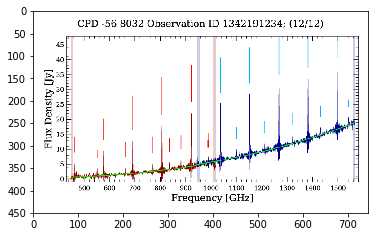

In [20]:
pURL, obsURL, contURL = getPaths(obsid, cal, obs_mod)
print('Postcard location: ', pURL)
img = mpimg.imread(pURL)
plt.imshow(img)
plt.show()
#webbrowser.open_new(pURL)

The `obsURL` and `contURL` variables point to the files containing the features catalogue and fitted continuum parameters for the specified observation. These will be used later.

It is also possible to download SPIRE spectral data directly from the Herschel Science Archive (HSA) using Python. These data can then be plotted along with features detected by the FF meeting a search criteria. Manipulating SPIRE spectral cubes is accomplished using the "spectral-cube" package of astropy, which may need to be installed by the user. SPIRE spectral data can be retrieved using the function `getSpireFtsData` defined below. 

Note that the `getSpireFtsData` function returns both "naive" and "convolved" spectral maps, and has options for both "apodized" and "unapodized" spectra. FF products, however, are only available for unapodized convolved spectral maps. Additionally, for sparse observations, the `getSpireFtsData` function is configured to return spectra from only the central "SLWC3" and "SSWD4" detectors. For sparse observations, FF products are only available for unapodized spectra from the central detectors. 

It should also be noted that many sparse observations processed by the FF use Highly Processed Data Products (HPDPs; http://archives.esac.esa.int/hsa/legacy/HPDP/SPIRE/SPIRE-S/cal_targets/) or Background Subtracted data (BGS; http://archives.esac.esa.int/hsa/legacy/HPDP/SPIRE/SPIRE-S/BKGS/). These specra are stored in a different location that the Standard Product Generation (SPG) spectra. To retrieve to spectrum processed by the FF, the appropriate data type (`specType`) must be specified in the `getSpireFtsData` function. 

In [57]:
def getSpireFtsData(obsid, cal, obs_mod, specType, apod=False, cache=True, tmpDir=""):
    """
    Using the HTTP access to HAIO, retrieve the level-2 products in a tar file
    and extract only the requested fits files
    
    cubeType can be 'convol' or 'naive'
    apod controls whether to extract the apodized version (if True)
    
    simple caching is impemented, checking of a tar file with the same name (OBSID based) already exists
    at the default folder.
    """
    
    spg_url = "http://archives.esac.esa.int/hsa/aio/jsp/"
    hpdp_url = "http://archives.esac.esa.int/hsa/legacy/HPDP/SPIRE/SPIRE-S/cal_targets/SPIREspec_calibrators/"
    bgs_url = "http://archives.esac.esa.int/hsa/legacy/HPDP/SPIRE/SPIRE-S/BKGS/spectra/"
    
    if obs_mod != 'full':
        detectors = ['SLWC3', 'SSWD4']
        specDets = {det:[] for det in detectors}
        headers = {det:[] for det in detectors}
    if specType == 'SPG':
        vers = '_spg_'
        if (apod): 
            vers = '_spgApod_'
        tarFile = tmpDir + "/%i_FTS_level2.tar"%obsid
        if (os.path.isfile(tarFile) and cache):
            print ("Found an already existing tar file for OBSID %i. Will Use it"%obsid)
        else:
            haioRequest = spg_url + "product.jsp?PROTOCOL=HTTP&OBSERVATION_ID=%i&PRODUCT_LEVEL=Level2"%obsid
            print ("Downloading level-2 data from the Herschel Science Archive. May take a while... be patient")
            r = requests.get(haioRequest)
            with open(tarFile, "wb") as tmp:
                tmp.write(r.content)
        # now read the downloaded tar file.
        with tarfile.open(tarFile,'r') as tar:
            if obs_mod == 'full': # mapping observations 
                cube = {}
                headers = {}
                for member in tar.getmembers():
                    if (('_20ssc_' in member.name) and (vers in member.name)):
                        ctype = 'naive'
                        if ('convol' in member.name):
                            ctype = 'convol'
                        f=tar.extractfile(member)
                        xx = fits.open(gzip.open(io.BytesIO(f.read())))
                        detx = xx[0].header['DETECTOR']
                        res = xx[0].header['PROC_RES']
                        # comined key for the output dictionary
                        xkey = "%s_%s_%s"%(detx,res,ctype)
                        cubeData = xx['image'].data
                        header = xx['image'].header
                        header["CTYPE3"] = "FREQ"
                        cube[xkey]= SpectralCube(data=cubeData, wcs=WCS(header))
                        headers[xkey] = xx[0].header
                return cube, headers, header
            elif obs_mod == 'sparse': # sparse observations
                calDict = {'pointSource':'point', 'extended':'ext'} 
                for member in tar.getmembers():
                    if (('_20s' in member.name) and (vers in member.name) and (calDict[cal] in member.name)):
                        f=tar.extractfile(member)
                        xx = fits.open(gzip.open(io.BytesIO(f.read())))
    else:
        if specType == 'HPDP':
            r = requests.get(hpdp_url)
            url = hpdp_url
        elif specType == 'BGS':
            r = requests.get(bgs_url)
            url = bgs_url
        else:
            print("Invalid specType")
            return False, False
        i_start = int(r.text.find(str(obsid)))
        if i_start == -1:
            print("No %s for observation %i"%(specType,obsid))
            return False, False
        i_end = i_start + int(r.text[i_start:].find('gz')) + 2
        gzFile = tmpDir + "/" + r.text[i_start:i_end]
        if (os.path.isfile(gzFile) and cache):
            print ("Found an already existing gz file for OBSID %i. Will Use it"%obsid)
        else:
            haioRequest = url + r.text[i_start:i_end]
            print ("Downloading %s data from the Archive. May take a while... be patient"%specType)
            r = requests.get(haioRequest)
            with open(gzFile, "wb") as tmp:
                tmp.write(r.content)
        xx = fits.open(gzip.open(gzFile))
    header0 = xx[0].header
    for det in detectors:
        specDets[det] = xx[det].data
        headers[det] = xx[det].header
    return specDets, header0, headers

### Sparse FF Producs and SPIRE Spectral Datasets

Currently our code is pointed at the observation 1342191234 which is a point source calibared sparse observation. To retrieve the SPIRE level-2 spectral data for this observation, we call the `getSpireFtsData` function as demonstrated below.

In [53]:
specData, header0, headers = getSpireFtsData(obsid, cal, obs_mod, specType, apod=False, cache=True, tmpDir=dataDir)

print('\nData keys:', specData.keys())
print('Header keys:', headers.keys())
target = header0['OBJECT']
target

Found an already existing tar file for OBSID 1342191234. Will Use it

Data keys: dict_keys(['SLWC3', 'SSWD4'])
Header keys: dict_keys(['SLWC3', 'SSWD4'])


'CPD -56 8032'

As can be seen, the "specData" and "headers" dictionaries contain entries for both central detectors. We will focus primarily on the frequency and flux axes of the spectral data. For more details about the data structure of SPIRE observations, the reader is referred to the SPIRE data reduction guide at http://herschel.esac.esa.int/hcss-doc-15.0/

With the spectral data in hand, we can now generate a plot of the spectral data and include the fitted continuum and additional lines to indicate spectral features detected by the FF. In principle, we could search the SAFECAT for the desired features as demonstrated above. This time, however, we will extracte the desired lines from the features catalogue specific to the 1342191234 observation. The location of the observation specific features catalogue and its fitted continuum parameters are currently stored in the `obsFile` and `contFile` variables, respectively, defined above. When plotting lines to indicated the position of desired features, these lines will be proportional to the associated SNRs of the features, much like the lines in the FF postcards. 

In [32]:
# download observation specific catalogue and continuum, directly from the URL
data = Table.read(obsURL)
data.info

<Table length=24>
     name       dtype  unit
-------------- ------- ----
     frequency float64  GHz
frequencyError float64  GHz
           SNR float64     
      detector  bytes5     
   featureFlag float64     
       nccFlag   int32     

In [33]:
features = data['frequency']
snr = data['SNR']
detector = data['detector']
velocity = data.meta['RV']
velocity_error = data.meta['RV_ERR']

# select lines of interest
freqRange = (900.0, 1500.0)
ind = np.where((features >= min(freqRange)) & (features <= max(freqRange)))[0]
print ("Found {} features".format(len(ind)))

Found 14 features


In [34]:
cont = Table.read(contURL)
cont

detector,p0,p0err,p1,p1err,p2,p2err,p3,p3err
bytes5,float64,float64,float64,float64,float64,float64,float64,float64
SLWC3,2.0803172315680443,0.8643134589692292,-0.008540590145382785,0.0037327835377905993,1.2376406836031502e-05,5.2236273324398726e-06,-6.141814602446233e-10,2.3742383765307368e-09
SSWD4,4.3619082632774555,3.5053072243985115,-0.010111665122179932,0.00854822033671272,9.76269162287522e-06,6.872664414606499e-06,1.6774531123453056e-09,1.8224158102806011e-09


In [35]:
x_slw, y_slw = specData['SLWC3']['wave'], specData['SLWC3']['flux']
x_ssw, y_ssw = specData['SSWD4']['wave'], specData['SSWD4']['flux']
cont_slw = cont['p0'][0] + cont['p1'][0]*x_slw + cont['p2'][0]*x_slw**2 + cont['p3'][0]*x_slw**3
cont_ssw = cont['p0'][1] + cont['p1'][1]*x_ssw + cont['p2'][1]*x_ssw**2 + cont['p3'][1]*x_ssw**3
flux_range = (max([max(y_slw),max(y_ssw)]) - min([min(y_slw),min(y_ssw)]))
offset = flux_range*0.05
scale = flux_range/max(snr)/2.0

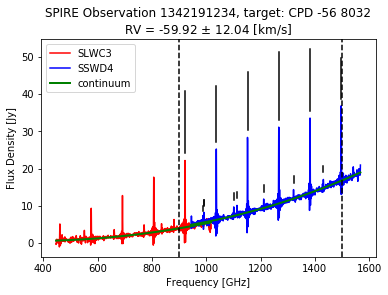

In [54]:
# plotting
fig = plt.figure(0)
plt.clf()
plt.title('SPIRE Observation %i, target: %s\nRV = %.2f $\\pm$ %.2f [km/s]'%(obsid, target, velocity, velocity_error))
plt.plot(x_slw, y_slw, 'r', label='SLWC3')
plt.plot(x_ssw, y_ssw, 'b', label='SSWD4')
plt.plot(x_slw, cont_slw, 'g', linewidth=2.0, label='continuum')
plt.plot(x_ssw, cont_ssw, 'g', linewidth=2.0)
for i in ind:
    freq = features[i]
    sn = snr[i]*scale
    det = detector[i]
    base = specData[det]['flux'][np.where(min(abs(specData[det]['wave'] - freq)) == abs(specData[det]['wave'] - freq))[0]]
    plt.plot([freq, freq], [base+offset, base+offset+sn], 'k')
limits = plt.ylim()
plt.plot([min(freqRange), min(freqRange)],[min(limits), max(limits)], '--k')
plt.plot([max(freqRange), max(freqRange)],[min(limits), max(limits)], '--k')
plt.ylim(limits)
plt.xlabel('%s [%s]'%(headers['SLWC3'].comments['TTYPE1'],headers['SLWC3']['TUNIT1']))
plt.ylabel('%s [%s]'%(headers['SLWC3'].comments['TTYPE2'],headers['SLWC3']['TUNIT2']))
plt.legend(loc=0);

### Mapping FF Producs and SPIRE Spectral Datasets

We now turn to mapping observations. SPIRE data for mapping observations is packaged into "spectral cubes" which are 3-dimensional data structures. Two axes correspond to pixel coordinates wich represent different locations on-sky. The third axis corresponds to the spectral data. Various cubes for the same mapping observation can be accessed from the HSA and retrieved using the `getSpireFtsData` fucntion. FF products, however, are only available for High Resolution (HR) unapodized SLW and SSW convolved cubes. Details about the varous cubes can be found in the SPIRE data reduction guide at http://herschel.esac.esa.int/hcss-doc-15.0/ 

We begin by reassigning some vaiables, and retrieving the SPIRE data for a mapping observation.

Postcard location:  http://archives.esac.esa.int/hsa/legacy/HPDP/SPIRE/SPIRE-S/spectral_feature_catalogue/HRmapping/postcards/1342192174_postcard_comb_2x3.png


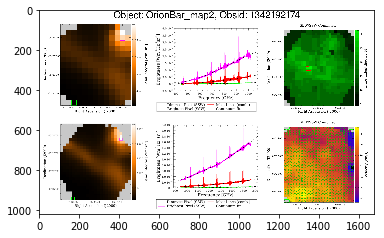

In [55]:
obsid = 1342192174
cal = 'extended'
obs_mod = 'full'
specType = 'SPG'

pURL, obsURL, contURL = getPaths(obsid, cal, obs_mod)
print('Postcard location: ', pURL)
img = mpimg.imread(pURL)
plt.imshow(img)
plt.show()

In [67]:
#webbrowser.open_new(archive + pURL)

specData, header0, headers = getSpireFtsData(obsid, cal, obs_mod, specType, apod=False, cache=True, tmpDir=dataDir)
cube_slw, cube_ssw = specData['SLW_HR_convol'], specData['SSW_HR_convol']
header_slw, header_ssw = cube_slw.header, cube_ssw.header
d_slw, d_ssw = header_slw['CDELT2'], header_ssw['CDELT2']  # pixel widths of SLW and SSW maps, respectively
for kk in header0.keys(): target = header0[kk]["OBJECT"] ; break
print (f'Target: {target}')

Found an already existing tar file for OBSID 1342192174. Will Use it
Target: OrionBar_map2


In [68]:
print ("Target: %s"%target)
print('SLW Cube\n Shape: %i Rows, %i Columns'%(header_slw['NAXIS2'], header_slw['NAXIS1']),\
      '\n Pixel width: %0.4f [%s]'%(d_slw, header_slw['CUNIT2']))
print('SSW Cube\n Shape: %i Rows, %i Columns'%(header_ssw['NAXIS2'], header_ssw['NAXIS1']),\
      '\n Pixel width: %0.4f [%s]'%(d_ssw, header_ssw['CUNIT2']))

Target: OrionBar_map2
SLW Cube
 Shape: 15 Rows, 13 Columns 
 Pixel width: 0.0049 [deg]
SSW Cube
 Shape: 27 Rows, 25 Columns 
 Pixel width: 0.0026 [deg]


As can be inferred from the dimensions of the SLW and SSW maps, in addition to their respective pixel widths, the SLW and SSW maps do not occupy the same footprint on-sky. This disparity can be easily seen in the mapping postcard. As such, one needs to take care when selecting SLW and SSW pixels if one wishes to inspect the same location on-sky with both maps. Below we demonstrat how to find the nearest SLW pixel given an initial SSW pixel using the FF products. We perform this operation with the observation specific features catalogue but the process in nearly identical when performed on the SAFECAT.

In [71]:
# download observation specific catalogue
# cannot use Table for multi-extension tables
hdu = fits.open(obsURL)
hdu.info()
FF_data = hdu['data']
velocity_map = hdu['velocity']
header = hdu['data'].header
hdu.close()

Filename: /Users/ivaltcha/.astropy/cache/download/py3/03a994f9a5a66024c7941ed25b403608
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      65   ()      
  1  data          1 BinTableHDU    148   6573R x 13C   [1D, 1D, 1D, 3A, 1K, 1K, 1D, 1D, 1D, 1D, 1D, 3A, 1J]   
  2  velocity      1 BinTableHDU    128   27R x 25C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D]   
  3  velocityError    1 BinTableHDU    128   27R x 25C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D]   
  4  vFlags        1 BinTableHDU    153   27R x 25C   [6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A]   
  5  nLines        1 BinTableHDU    128   27R x 25C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D]   
  6  arrays        1 BinTableHDU    153   27R x 25C  

## (IVAN) up to here with modifications

In [18]:
contFile = downloadProduct(contURL, dataDir)
# reference SSW pixel (SPIRE data)
c_col = int(header_ssw['CRPIX1'])-1
c_row = int(header_ssw['CRPIX2'])-1
c_ra, c_dec = header_ssw['CRVAL1'], header_ssw['CRVAL2']

Product already downloaded
Product already downloaded


In [19]:
#wcs = WCS(header_ssw)
#c = SkyCoord(c_ra,c_dec,frame='icrs',unit=(u.deg, u.deg))
#xp,yp = c.to_pixel(wcs)
#print (xp,yp,c_row,c_col)

In [20]:
# get indicies for all entries from reference SSW pixel (FF products)
ssw_ind = np.where((FF_data['row'] == (c_row)) & (FF_data['column'] == c_col) & (FF_data['array'] == 'SSW'))[0]
ssw_ra, ssw_dec = np.unique(FF_data['ra'][ssw_ind]), np.unique(FF_data['dec'][ssw_ind])
ssw_row, ssw_col = np.unique(FF_data['row'][ssw_ind]), np.unique(FF_data['column'][ssw_ind])

In [23]:
wcs = WCS(header_ssw)
c = SkyCoord(ssw_ra[0],ssw_dec[0],frame='icrs',unit=(u.deg, u.deg))
xp,yp = c.to_pixel(wcs)
print (xp,ssw_col,yp,ssw_row)

12.0 [12] 13.000000000015792 [13]


In [24]:
# check that we are looking at the same on-sky location
if (min(abs(ssw_ra - c_ra)) > d_ssw/2.0) or (min(abs(ssw_dec - c_dec)) > d_ssw/2.0):
    print('SPIRE data and FF product coordinates do NOT match within half resolution of SSW mapping pixel.')
else:
    print('SPIRE data and FF product coordinates DO match within half resolution of SSW mapping pixel.')
    
# get indicies for all entries from SLW pixel nearest central SSW pixel (FF products)
slw_ind = np.where((abs(FF_data['ra'] - ssw_ra) <= d_slw/2.0) & (abs(FF_data['dec'] - ssw_dec) <= d_slw/2.0)\
                   & (FF_data['array'] == 'SLW'))[0]
slw_ra, slw_dec = np.unique(FF_data['ra'][slw_ind]), np.unique(FF_data['dec'][slw_ind])
slw_row, slw_col = np.unique(FF_data['row'][slw_ind]), np.unique(FF_data['column'][slw_ind])

print('\n     row   column\nSLW   %i    %i\nSSW   %i    %i'%(slw_row, slw_col, ssw_row, ssw_col))
print('\nFF coordinates of central SSW pixel = (%f, %f)'%(ssw_ra[0], ssw_dec[0]))
print('FF coordinates of nearest SLW pixel = (%f, %f)'%(slw_ra[0], slw_dec[0]))

SPIRE data and FF product coordinates DO match within half resolution of SSW mapping pixel.

     row   column
SLW   7    6
SSW   13    12

FF coordinates of central SSW pixel = (83.832625, -5.424556)
FF coordinates of nearest SLW pixel = (83.832625, -5.424556)


As can be seen from the above printout, we have successfully located the SLW pixel nearest the central SSW pixel. For our example, the coordinates for both pixels are identical but this need no be the case in general. 

Having determined which SLW and SSW pixels we wish to inspect, we can now generate a plot similar to the one generated for our example sparse observation. 

In [25]:
# organize FF results 
features, snr, array = [], [], []

features.extend(FF_data['frequency'][slw_ind])
snr.extend(FF_data['snr'][slw_ind])
array.extend(FF_data['array'][slw_ind])

features.extend(FF_data['frequency'][ssw_ind])
snr.extend(FF_data['snr'][ssw_ind])
array.extend(FF_data['array'][ssw_ind])

features = np.array(features)
slw_velocity, ssw_velocity = np.mean(FF_data['velocity'][slw_ind]), np.mean(FF_data['velocity'][ssw_ind])
slw_vel_error, ssw_vel_error = np.mean(FF_data['velocityError'][slw_ind]), np.mean(FF_data['velocityError'][ssw_ind])

In [41]:
# organize SPIRE data
x_slw, y_slw = cube_slw.spectral_axis.value/1.0e9, cube_slw.unmasked_data[:,slw_row[0],slw_col[0]].value
x_ssw, y_ssw = cube_ssw.spectral_axis.value/1.0e9, cube_ssw.unmasked_data[:,ssw_row[0],ssw_col[0]].value
flux = {'SLW':y_slw, 'SSW':y_ssw}
wave = {'SLW':x_slw, 'SSW':x_ssw}

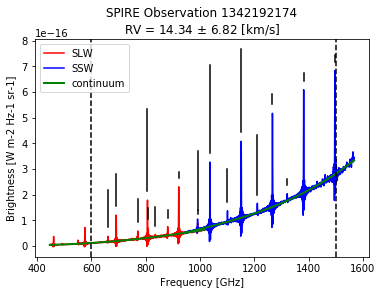

In [44]:
# generate continua
hdulist = fits.open(contFile)
cont_data = hdulist[1].data
hdulist.close()

cont_slw_ind = np.where((cont_data['row'] == slw_row[0]) & (cont_data['column'] == slw_col[0]) & (cont_data['array'] == 'SLW'))[0]
cont_ssw_ind = np.where((cont_data['row'] == ssw_row[0]) & (cont_data['column'] == ssw_col[0]) & (cont_data['array'] == 'SSW'))[0]

cont_data_slw = {key:vals for (key, vals) in zip(cont_data.names, cont_data[cont_slw_ind[0]])}
cont_data_ssw = {key:vals for (key, vals) in zip(cont_data.names, cont_data[cont_ssw_ind[0]])}

cont_slw = cont_data_slw['p0'] + cont_data_slw['p1']*x_slw + cont_data_slw['p2']*x_slw**2 + cont_data_slw['p3']*x_slw**3 
cont_ssw = cont_data_ssw['p0'] + cont_data_ssw['p1']*x_ssw + cont_data_ssw['p2']*x_ssw**2 + cont_data_ssw['p3']*x_ssw**3
flux_range = (max([max(y_slw),max(y_ssw)]) - min([min(y_slw),min(y_ssw)]))
offset = flux_range*0.05
scale = flux_range/max(snr)/2.

# select lines of interest
freqRange = (600.0, 1500.0)
ind = np.where((features >= min(freqRange)) & (features <= max(freqRange)))[0]

# plotting
fig = plt.figure(0)
plt.clf()
plt.title('SPIRE Observation %i\nRV = %.2f $\\pm$ %.2f [km/s]'\
        %(obsid, np.mean([slw_velocity, ssw_velocity]), np.mean([slw_vel_error, ssw_vel_error])))
plt.plot(x_slw, y_slw, 'r', label='SLW')
plt.plot(x_ssw, y_ssw, 'b', label='SSW')
plt.plot(x_slw, cont_slw, 'g', linewidth=2.0, label='continuum')
plt.plot(x_ssw, cont_ssw, 'g', linewidth=2.0)
for i in ind:
    freq = features[i]
    sn = snr[i]*scale
    ary = array[i]
    base = flux[ary][np.where(min(abs(wave[ary] - freq)) == abs(wave[ary] - freq))[0]]
    plt.plot([freq, freq], [base+offset, base+offset+sn], 'k')
limits = plt.ylim()
plt.plot([min(freqRange), min(freqRange)],[min(limits), max(limits)], '--k')
plt.plot([max(freqRange), max(freqRange)],[min(limits), max(limits)], '--k')
plt.ylim(limits)
plt.xlabel('Frequency [GHz]')
plt.ylabel('Brightness [W m-2 Hz-1 sr-1]')
plt.legend(loc=0);

### Velocity Maps

stuff

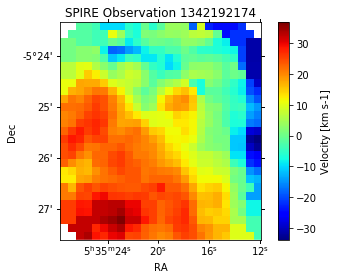

In [45]:
# generate World Coordinate System (WCS) object from SPIRE HSA observation
wcs_hsa = WCS(header_ssw)
wcs_new = WCS(naxis=2)

wcs_new.wcs.crpix = wcs_hsa.wcs.crpix[:2]
wcs_new.wcs.cdelt = wcs_hsa.wcs.cdelt[:2]
wcs_new.wcs.crval = wcs_hsa.wcs.crval[:2]
wcs_new.wcs.ctype = ["RA---TAN", "DEC--TAN"]

# becasue FITS_rec is weird
v_map = []
for row in velocity_map:
    v_map.append(np.array(row))

# plotting
fig = plt.figure()
fig.add_subplot(111, projection=wcs_new)
plt.title('SPIRE Observation %i'%obsid)
plt.imshow(v_map,  origin='lower', cmap='jet')
plt.colorbar(label='Velocity [%s]'%header['TUNIT11'])
plt.xlabel('RA')
plt.ylabel('Dec')

# Integrated Flux

When analysing a spectrum, one is often interested in the integrated flux of spectral features. Integrated flux of spectral features is not provided in the FF products because obtaining accurate values typically requires careful analysis of the associated spectra. With this consideration, we demonstate below a simple approach for obtaining rough estimates of the integrated flux for features detected by the FF. 

The proposed procedure involves fitting detected features using a Sinc model, which closely approximates the empirical line shape of the SPIRE FTS, and extracting the integraed flux analitically from the fitted line parameters. This process is similar to the method employed by the the standard spectral line fitting analysis sciript used by the Herschel Interactive Processing Environment (HIPE). Typically one would include the continuum in the fitted model, but in our case, we will simply use continumm subtracted spectral data where the fitted continuum is provided by the FF. 

Note: The Sinc function expresses decaying side-lobes which produce non-local effects in the spectrum. For this reasons, fitting a single spectral feature is not recomnded. The best most phisically real results are obtained when simutaneously fitting all detected features in the spectrum (ie, either the entire SLW or SSW band). We will perform our analysis on the already loaded SLW spectrum from above.

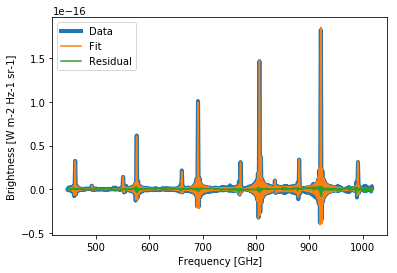

Frequency [GHz]     Flux [W m-2 sr-1]     Flux Error [W m-2 sr-1]

   461.01               3.87e-08                  5.59e-10

   492.14               4.43e-09                  5.58e-10

   550.94               1.78e-08                  5.58e-10

   576.28               7.3e-08                  5.58e-10

   661.08               2.55e-08                  5.58e-10

   691.44               1.2e-07                  5.58e-10

   771.13               3.66e-08                  5.58e-10

   806.62               1.77e-07                  5.61e-10

   809.30               2.26e-08                  5.61e-10

   835.11               1.11e-08                  5.58e-10

   881.25               3.94e-08                  5.58e-10

   921.75               2.23e-07                  5.58e-10

   991.32               3.68e-08                  5.59e-10



In [46]:
specIn = y_slw - cont_slw # input continuum subtracted spectrum
fitFeatures = sorted(FF_data['frequency'][slw_ind])

def sincModel(xdata, amp, cent, width = 1.18448225): 
    p2 = width/np.pi
    arg = (xdata - cent)/p2
    return amp*np.sin(arg)/arg

totalModel = None
specRes = headers['SLW_HR_convol']['ACTRES']
prefs = []

for i in range(len(fitFeatures)):
    pref = '_%i'%i
    prefs.append(pref)
    freq = fitFeatures[i]
    ind = np.where(min(abs(freq - x_slw)) == abs(freq - x_slw))[0]
    amp = specIn[ind]
    newMod = Model(sincModel, prefix=pref)
    newMod.set_param_hint(pref+'amp', value=amp, vary=True)
    newMod.set_param_hint(pref+'cent', value=freq, vary=False)
    newMod.set_param_hint(pref+'width', value=specRes, vary=False) # set vary to True for partially resolved features
    if totalModel == None:
        totalModel = newMod
    else:
        totalModel += newMod
        
result = totalModel.fit(specIn, xdata=x_slw)

fig = plt.figure(0)
plt.clf()
plt.plot(x_slw, specIn, linewidth=4.0, label='Data')
plt.plot(x_slw, result.best_fit, label='Fit')
plt.plot(x_slw, result.residual, label='Residual')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Brightness [W m-2 Hz-1 sr-1]')
plt.legend(loc=0)
plt.show()

fitPars = result.params
print('Frequency [GHz]     Flux [W m-2 sr-1]     Flux Error [W m-2 sr-1]\n')
for pref in prefs:
    amp = fitPars['%samp'%pref]
    freq = fitPars['%scent'%pref]
    width = fitPars['%swidth'%pref]
    flux = amp.value*1e9*width.value # may need to multiply by pi
    fluxErr = flux*np.sqrt((amp.stderr/amp.value)**2 + (width.stderr/width.value)**2)
    print('   %.2f               %.3g                  %.3g\n'%(freq.value, flux, fluxErr))


The above example was perfomred on a spectrum which has been processed using the extended sources callibration scheme. When integrating line flux for spectra processed using the point-source callibration scheme, the `flux` varriable must be multiplied by 10^-26 to convert from [Jy] to [W m-2 Hz-1]. Additionally, in the above example we have assumed the spectral features are not resloved. When analysing partially or fully resolved spectral features, best results are obtained when modeling the spectral features as Sinc convolved Gaussians. However, for a quick estimate of integrated flux, one can simply set the `vary` keyword for the `width` varriable in the fitter object to True. The large majority of spectral featues in the SPIRE FTS dataset are unresolved and the above script should be sufficient in most cases. 

# Conclusion

stuff 2.0
